In [1]:
import pandas as pd
import numpy as np
import fastsparsegams
np.random.seed(0)
df = pd.read_csv('./fico_full.csv')

In [2]:
df = df[df.columns[[-9, -5, -4, -3, -2, -1]]] #highest missingness prop

In [3]:
# df = df[df.columns[-10:]]

In [4]:
for c in df.columns:
    print(f"Missing rate for {c}", df[df[c] <= -7].shape[0] / df[c].shape[0])

Missing rate for MSinceMostRecentInqexcl7days 0.27908977913758487
Missing rate for NetFractionInstallBurden 0.3831150205564586
Missing rate for NumRevolvingTradesWBalance 0.0711349077349651
Missing rate for NumInstallTradesWBalance 0.1385409694999522
Missing rate for NumBank2NatlTradesWHighUtilization 0.11196099053446792
Missing rate for PoorRiskPerformance 0.0


In [5]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2, stratify=df['PoorRiskPerformance'])

In [6]:
train_df.shape

(8367, 6)

In [7]:
def binarize_according_to_train(train_df, test_df, overall_mi_intercept = True, overall_mi_ixn = True, specific_mi_intercept = True, specific_mi_ixn = True):
    n_train, d_train = train_df.shape
    n_test, d_test = test_df.shape
    train_binned, train_augmented_binned, test_binned, test_augmented_binned = {}, {}, {}, {}
    train_no_missing, test_no_missing = {}, {}
    for c in train_df.columns:
        if c == 'PoorRiskPerformance':
            continue
        missing_col_name = f'{c} missing'
        missing_row_train = np.zeros(n_train)
        missing_row_test = np.zeros(n_test)
        for v in list(train_df[c].quantile([0.2, 0.4, 0.6, 0.8, 1]).unique()) + [-7, -8, -9]:
            if v in [-7, -8, -9]:

                if specific_mi_intercept:
                    new_col_name = f'{c} == {v}'
    
                    new_row_train = np.zeros(n_train)
                    new_row_train[train_df[c] == v] = 1
                    train_binned[new_col_name] = new_row_train
                    train_augmented_binned[new_col_name] = new_row_train
                    
                    new_row_test = np.zeros(n_test)
                    new_row_test[test_df[c] == v] = 1
                    test_binned[new_col_name] = new_row_test
                    test_augmented_binned[new_col_name] = new_row_test

                missing_row_train[train_df[c] == v] = 1
                missing_row_test[test_df[c] == v] = 1
            else:
                new_col_name = f'{c} <= {v}'

                new_row_train = np.zeros(n_train)
                new_row_train[train_df[c] <= v] = 1
                train_no_missing[new_col_name] = new_row_train
                train_binned[new_col_name] = new_row_train
                train_augmented_binned[new_col_name] = new_row_train
                
                new_row_test = np.zeros(n_test)
                new_row_test[test_df[c] <= v] = 1
                test_no_missing[new_col_name] = new_row_test
                test_binned[new_col_name] = new_row_test
                test_augmented_binned[new_col_name] = new_row_test

        if overall_mi_intercept: 
            train_binned[missing_col_name] = missing_row_train
            train_augmented_binned[missing_col_name] = missing_row_train
        
            test_binned[missing_col_name] = missing_row_test
            test_augmented_binned[missing_col_name] = missing_row_test
    
    for c_outer in train_df.columns:
        if c_outer == 'PoorRiskPerformance':
            continue
        for c_inner in train_df.columns:
            for v in train_df[c_inner].quantile([0.2, 0.4, 0.6, 0.8, 1]).unique():
                if (v in [-7, -8, -9]) or c_inner == 'PoorRiskPerformance':
                    continue
                else:
                    missing_ixn_name = f'{c_outer} missing & {c_inner} <= {v}'
                    missing_ixn_row_train = np.zeros(n_train)
                    missing_ixn_row_test = np.zeros(n_test)
                    for m_val in [-7, -8, -9]:
                        if specific_mi_ixn: 
                            new_col_name = f'{c_outer}_missing_{m_val} & {c_inner} <= {v}'
    
                            new_row_train = np.zeros(n_train)
                            new_row_train[(train_df[c_outer] == m_val) & (train_df[c_inner] <= v)] = 1
                            train_augmented_binned[new_col_name] = new_row_train
    
                            new_row_test = np.zeros(n_test)
                            new_row_test[(test_df[c_outer] == m_val) & (test_df[c_inner] <= v)] = 1
                            test_augmented_binned[new_col_name] = new_row_test

                        missing_ixn_row_train[(train_df[c_outer] == m_val) & (train_df[c_inner] <= v)] = 1
                        missing_ixn_row_test[(test_df[c_outer] == m_val) & (test_df[c_inner] <= v)] = 1

                    if overall_mi_ixn: 
                        train_augmented_binned[missing_ixn_name] = missing_ixn_row_train
                        test_augmented_binned[missing_ixn_name] = missing_ixn_row_test
                        
    train_binned['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_binned['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    train_no_missing['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_no_missing['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    train_augmented_binned['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_augmented_binned['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    return pd.DataFrame(train_no_missing), pd.DataFrame(train_binned), pd.DataFrame(train_augmented_binned), \
         pd.DataFrame(test_no_missing), pd.DataFrame(test_binned), pd.DataFrame(test_augmented_binned)

In [8]:
train_no_missing, train_binned, train_binned_augmented, test_no_missing, test_binned, test_binned_augmented = binarize_according_to_train(train_df, test_df)

X_indicator_train = train_binned[train_binned.columns[:-1]].values
y_train = train_binned['PoorRiskPerformance'].values

X_indicator_test = test_binned[test_binned.columns[:-1]].values
y_test = test_binned['PoorRiskPerformance'].values

X_no_missing_train = train_no_missing[train_no_missing.columns[:-1]].values
X_no_missing_test = test_no_missing[test_no_missing.columns[:-1]].values

X_aug_train = train_binned_augmented[train_binned_augmented.columns[:-1]].values
X_aug_test = test_binned_augmented[test_binned_augmented.columns[:-1]].values

In [9]:
X_indicator_train.shape

(8367, 42)

In [10]:
X_aug_train.shape

(8367, 442)

In [11]:
model_no_missing = fastsparsegams.fit(
    X_no_missing_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=40, algorithm="CDPSI"
)

In [12]:
model_indicator = fastsparsegams.fit(
    X_indicator_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=40, algorithm="CDPSI"
)

In [13]:
model_aug = fastsparsegams.fit(
    X_aug_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=40, algorithm="CDPSI"
)

In [14]:
#recover coefficients and train/test probabilities
def eval_model(model, X_train, X_test, col_names): 
    coeffs = np.zeros((len(model.lambda_0[0]), X_train.shape[1]))
    missing_coeffs = np.zeros((len(model.lambda_0[0])))
    inter_coeffs = np.zeros((len(model.lambda_0[0])))
    train_probs = np.zeros((len(model.lambda_0[0]), X_train.shape[0]))
    test_probs = np.zeros((len(model.lambda_0[0]), X_test.shape[0]))

    for i, lamby in enumerate(model.lambda_0[0]): 
        train_probs[i] = model.predict(X_train.astype(float),lambda_0=lamby).reshape(-1)
        test_probs[i] = model.predict(X_test.astype(float),lambda_0=lamby).reshape(-1)

        cur_col_names = col_names[(model.coeff(lambda_0=lamby).toarray().flatten()[1:] != 0)]
        missing_coeffs[i] = sum(['-' in c for c in cur_col_names])
        inter_coeffs[i] = sum(['&' in c for c in cur_col_names])
        coeffs[i] = (model.coeff(lambda_0=lamby).toarray().flatten())[1:] #first entry is intercept
    return train_probs, test_probs, coeffs, missing_coeffs, inter_coeffs

In [15]:
train_probs_aug, test_probs_aug, coeff_aug, missing_coeff_aug, inter_coeffs = eval_model(model_aug, X_aug_train, 
                                                                            X_aug_test, train_binned_augmented.columns[:-1])
trainacc_aug = ((train_probs_aug > 0.5) == y_train).mean(axis = 1)
testacc_aug = ((test_probs_aug > 0.5) == y_test).mean(axis = 1)
num_terms_aug = (coeff_aug != 0).sum(axis=1)

In [16]:
train_probs_indicator, test_probs_indicator, coeff_indicator, missing_coeff_indicator, _ = eval_model(model_indicator, 
                                                                                                    X_indicator_train, 
                                                                                                    X_indicator_test,
                                                                                                    train_binned.columns[:-1])
trainacc_indicator = ((train_probs_indicator > 0.5) == y_train).mean(axis=1)
testacc_indicator = ((test_probs_indicator > 0.5) == y_test).mean(axis=1)
num_terms_indicator = (coeff_indicator != 0).sum(axis=1)

In [17]:
train_probs_no_missing, test_probs_no_missing, coeff_no_missing, missing_coeff_no_missing, _ = eval_model(model_no_missing, X_no_missing_train, X_no_missing_test, train_no_missing.columns[:-1])
trainacc_no_missing = ((train_probs_no_missing > 0.5) == y_train).mean(axis=1)
testacc_no_missing = ((test_probs_no_missing > 0.5) == y_test).mean(axis=1)
num_terms_no_missing = (coeff_no_missing != 0).sum(axis=1)

In [18]:
print(trainacc_no_missing)

[0.5219314  0.5219314  0.5219314  0.5219314  0.5219314  0.5219314
 0.5219314  0.5219314  0.5219314  0.5219314  0.5219314  0.5219314
 0.5219314  0.5219314  0.5219314  0.5219314  0.5219314  0.5219314
 0.5219314  0.5219314  0.5219314  0.5219314  0.5219314  0.5219314
 0.5219314  0.5219314  0.5219314  0.5219314  0.5219314  0.5219314
 0.5219314  0.5219314  0.5219314  0.5219314  0.5219314  0.5219314
 0.5219314  0.5219314  0.5219314  0.5219314  0.5219314  0.5219314
 0.5999761  0.5999761  0.5999761  0.60212741 0.60212741 0.60212741
 0.60212741 0.60212741 0.60212741 0.60212741 0.60212741 0.60212741
 0.62746504 0.62746504 0.62746504 0.62746504 0.62746504 0.62746504
 0.62746504 0.62746504 0.62746504 0.62746504 0.63045297 0.63045297
 0.63045297 0.63045297 0.63117007 0.63117007 0.6299749  0.6299749
 0.63224573 0.63224573 0.63224573 0.63224573 0.63224573 0.63224573
 0.63224573 0.63224573 0.63188718 0.63188718 0.63164814 0.63164814
 0.63164814 0.63164814 0.63164814 0.63164814 0.63164814 0.63164814
 0.

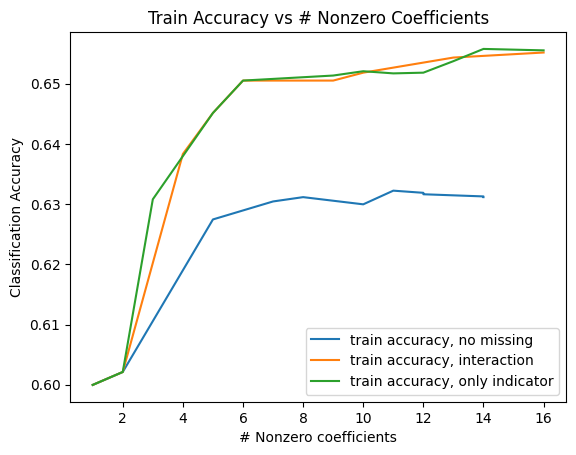

In [19]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Train Accuracy vs # Nonzero Coefficients')#\n (Other than intercept)
plt.plot(num_terms_no_missing[num_terms_no_missing > 0], trainacc_no_missing[num_terms_no_missing > 0], label='train accuracy, no missing')
plt.plot(num_terms_aug[num_terms_aug > 0], trainacc_aug[num_terms_aug > 0], label='train accuracy, interaction')
plt.plot(num_terms_indicator[num_terms_indicator > 0], trainacc_indicator[num_terms_indicator > 0], label='train accuracy, only indicator')
plt.ylabel('Classification Accuracy')
plt.xlabel('# Nonzero coefficients')

plt.legend()

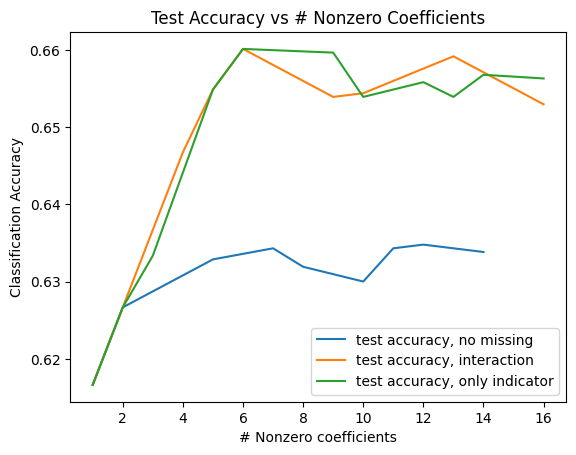

In [20]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Test Accuracy vs # Nonzero Coefficients')#\n (Other than intercept)
plt.plot(num_terms_no_missing[num_terms_no_missing > 0], testacc_no_missing[num_terms_no_missing > 0], label='test accuracy, no missing')
plt.plot(num_terms_aug[num_terms_aug > 0], testacc_aug[num_terms_aug > 0], label='test accuracy, interaction')
plt.plot(num_terms_indicator[num_terms_indicator > 0], testacc_indicator[num_terms_indicator > 0], label='test accuracy, only indicator')
plt.ylabel('Classification Accuracy')
plt.xlabel('# Nonzero coefficients')

plt.legend()

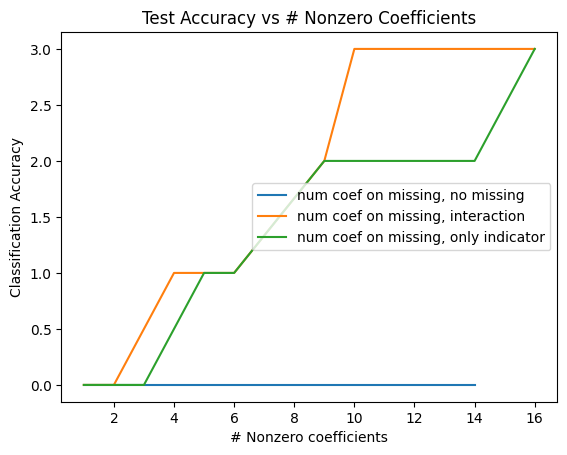

In [21]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Test Accuracy vs # Nonzero Coefficients')#\n (Other than intercept)
plt.plot(num_terms_no_missing[num_terms_no_missing > 0], missing_coeff_no_missing[num_terms_no_missing > 0], label='num coef on missing, no missing')
plt.plot(num_terms_aug[num_terms_aug > 0], missing_coeff_aug[num_terms_aug > 0], label='num coef on missing, interaction')
plt.plot(num_terms_indicator[num_terms_indicator > 0], missing_coeff_indicator[num_terms_indicator > 0], label='num coef on missing, only indicator')
plt.ylabel('Classification Accuracy')
plt.xlabel('# Nonzero coefficients')

plt.legend()

In [22]:
lam = 2

names = train_binned_augmented.columns[:-1][abs(model_aug.coeff(lambda_0=lam).toarray().flatten()[1:]) > 0]
coef_dict = {}
for i, v in enumerate(model_aug.coeff(lambda_0=lam).toarray().flatten()[1:][abs(model_aug.coeff(lambda_0=lam).toarray().flatten()[1:]) > 0]):
    coef_dict[names[i]] = v
#print(names)
print(coef_dict)

{'MSinceMostRecentInqexcl7days <= 0.0': 0.43451617648993157, 'NetFractionInstallBurden <= 62.0': -0.16652448319636762, 'NumBank2NatlTradesWHighUtilization <= 0.0': -0.31065445501523054, 'NumBank2NatlTradesWHighUtilization <= 1.0': -0.15127438147145514, 'NumBank2NatlTradesWHighUtilization <= 2.0': -0.20587290316114806, 'MSinceMostRecentInqexcl7days_missing_-8 & NumRevolvingTradesWBalance <= 29.0': -0.9490052312331572, 'NetFractionInstallBurden_missing_-8 & NumRevolvingTradesWBalance <= 1.0': 0.2572037926009499, 'NetFractionInstallBurden_missing_-8 & NumInstallTradesWBalance <= 2.0': 0.1236565180267589, 'NetFractionInstallBurden missing & NumBank2NatlTradesWHighUtilization <= 0.0': -0.23875593605327672, 'NumBank2NatlTradesWHighUtilization missing & NumBank2NatlTradesWHighUtilization <= 2.0': 0.5770369783308674}


MSinceMostRecentDelq_missing & AverageMInFile is a pretty interesting term -- MSinceMostRecentDelq is Months Since Most Recent Delinquency and AverageMInFile is Average Months in File. So, if somebody has a larger n months in file, it might be more suspicious if the months since delinquency is missing.

In [23]:
names = train_binned.columns[:-1][abs(model_indicator.coeff(lambda_0=lam).toarray().flatten()[1:]) > 0]
coef_dict = {}
for i, v in enumerate(model_indicator.coeff(lambda_0=lam).toarray().flatten()[1:][abs(model_indicator.coeff(lambda_0=lam).toarray().flatten()[1:]) > 0]):
    coef_dict[names[i]] = v
print(len(coef_dict))
#print(names)
print(coef_dict)

9
{'MSinceMostRecentInqexcl7days <= 0.0': 0.4379113352702071, 'MSinceMostRecentInqexcl7days == -8': -0.9580700764781823, 'MSinceMostRecentInqexcl7days == -9': -0.4248434233272578, 'NetFractionInstallBurden <= 62.0': -0.13529743802686078, 'NumRevolvingTradesWBalance <= 1.0': 0.12570956733636937, 'NumBank2NatlTradesWHighUtilization <= 0.0': -0.39347276377765195, 'NumBank2NatlTradesWHighUtilization <= 1.0': -0.15290340977746972, 'NumBank2NatlTradesWHighUtilization <= 2.0': -0.20231167039768863, 'NumBank2NatlTradesWHighUtilization missing': 0.6229851558299728}


In [24]:
train_binned.columns[:-1][abs(model_indicator.coeff(lambda_0=0.06).toarray().flatten()[1:]) > 0]

Index(['MSinceMostRecentInqexcl7days <= 0.0',
       'MSinceMostRecentInqexcl7days <= 2.0',
       'MSinceMostRecentInqexcl7days == -8',
       'MSinceMostRecentInqexcl7days == -9',
       'NetFractionInstallBurden <= 62.0', 'NetFractionInstallBurden <= 83.0',
       'NumRevolvingTradesWBalance <= 1.0',
       'NumRevolvingTradesWBalance <= 4.0', 'NumRevolvingTradesWBalance == -9',
       'NumRevolvingTradesWBalance missing', 'NumInstallTradesWBalance <= 1.0',
       'NumInstallTradesWBalance <= 3.0',
       'NumBank2NatlTradesWHighUtilization <= 0.0',
       'NumBank2NatlTradesWHighUtilization <= 1.0',
       'NumBank2NatlTradesWHighUtilization <= 2.0',
       'NumBank2NatlTradesWHighUtilization missing'],
      dtype='object')

In [25]:

X_aug_train.shape

(8367, 442)